In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
exps = {
    'Text': 'w32a4-lut.text-0',
    'Vision': 'w32a4-lut.vision-0',
    'Hybrid': 'w32a4-lut.hybrid-0',
    'Split': 'w32a4-lut-1',
}
comps = ['self_attn.q_proj', 'self_attn.o_proj', 'mlp.up_proj', 'mlp.down_proj']

In [3]:
log_dir = '/home/chengzhang/Multimodal-Quantization/LLaVA/snapshot/eval-logs'
header = ['outliers_rate', 'outliers', 'total_vals', 'in_err', 'out_err']

def load_logs(exp_name, layer, comp):
    return pd.read_csv(os.path.join(log_dir, exp_name, f'model.layers.{layer}.{comp}.txt'), names=header)

In [4]:
def merge_split_data(df: pd.DataFrame):
    return df[0::2].reset_index(drop=True) + df[1::2].reset_index(drop=True)

def calc_outlier_rate(df: pd.DataFrame):
    df['outliers_rate'] = df['outliers'] / df['total_vals']
    return df

In [6]:
def collect_data(df: pd.DataFrame):
    return (
        df['outliers'].astype(np.int64).sum() / df['total_vals'].astype(np.int64).sum(),
        df['in_err'].astype(np.float64).sum(),
        df['out_err'].astype(np.float64).sum(),
    )

In [8]:
def load_comp(layer: int, comp: str):
    data = {modal: load_logs(exp_name, layer, comp) for modal, exp_name in exps.items()}
    data['Split'] = merge_split_data(data['Split'])
    data = {modal: calc_outlier_rate(df) for modal, df in data.items()}
    return data

def plot_comp(ax: plt.Axes, data: dict[str, pd.DataFrame], cat: str):
    for modal, df in data.items():
        ax.plot(df[cat], label=modal)
    ax.legend()
    ax.set_ylabel(cat)

collected = {
    comp: {
        modal: {
            'outliers_rate': [],
            'in_err': [],
            'out_err': [],
        } for modal in exps
    } for comp in comps
}

print('Layers: ', end='')
for layer in range(32):
    print(f'{layer}, ', end='')
    plt.figure(figsize=(12, 12))
    plt.subplots_adjust(hspace=0.3)
    for j, comp in enumerate(comps):
        data = load_comp(layer, comp)
        for modal, df in data.items():
            outliers_rate, in_err, out_err = collect_data(df)
            collected[comp][modal]['outliers_rate'].append(outliers_rate)
            collected[comp][modal]['in_err'].append(in_err)
            collected[comp][modal]['out_err'].append(out_err)
        ax = plt.subplot(4, 3, j * 3 + 1)
        plot_comp(ax, data, 'outliers_rate')
        ax.set_title(comp)
        if j == len(comps) - 1:
            ax.set_xlabel('batch_idx')
        ax = plt.subplot(4, 3, j * 3 + 2)
        plot_comp(ax, data, 'in_err')
        ax.set_title(comp)
        if j == len(comps) - 1:
            ax.set_xlabel('batch_idx')
        ax = plt.subplot(4, 3, j * 3 + 3)
        plot_comp(ax, data, 'out_err')
        ax.set_title(comp)
        if j == len(comps) - 1:
            ax.set_xlabel('batch_idx')
    plt.suptitle(f'Layer {layer}')
    plt.savefig(os.path.join(log_dir, 'img', f'layer-{layer:0>2}.png'))
    plt.close()

print(f'\nCollected: {collected}')

Layers: 0, 

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 
Collected: {'self_attn.q_proj': {'Text': {'outliers_rate': [0.04668706692856746, 0.14562752004071877, 0.09166003536151836, 0.07048726028502736, 0.060872688648216634, 0.05354329849828416, 0.0553755273713088, 0.05325255670012818, 0.051940022494021, 0.05159000303568724, 0.049104030969917736, 0.05125870687509558, 0.05226780540188245, 0.051707471586197304, 0.05021643731396455, 0.04696714227445272, 0.04772205230821948, 0.04249494573303244, 0.039364839201116206, 0.0371405806984943, 0.036584123956278955, 0.036135262080687965, 0.03678700773819352, 0.03275585869314961, 0.03268593282432504, 0.03230334663652026, 0.03297195801869881, 0.030695869137803103, 0.03037901343254454, 0.03188640851389862, 0.029769491611095333, 0.03024994739817128], 'in_err': [1539489.067031622, 2996483.2029985785, 12881239.129324615, 33890415.25552279, 27544363.59367633, 32058687.930197418, 46596680.45482403, 

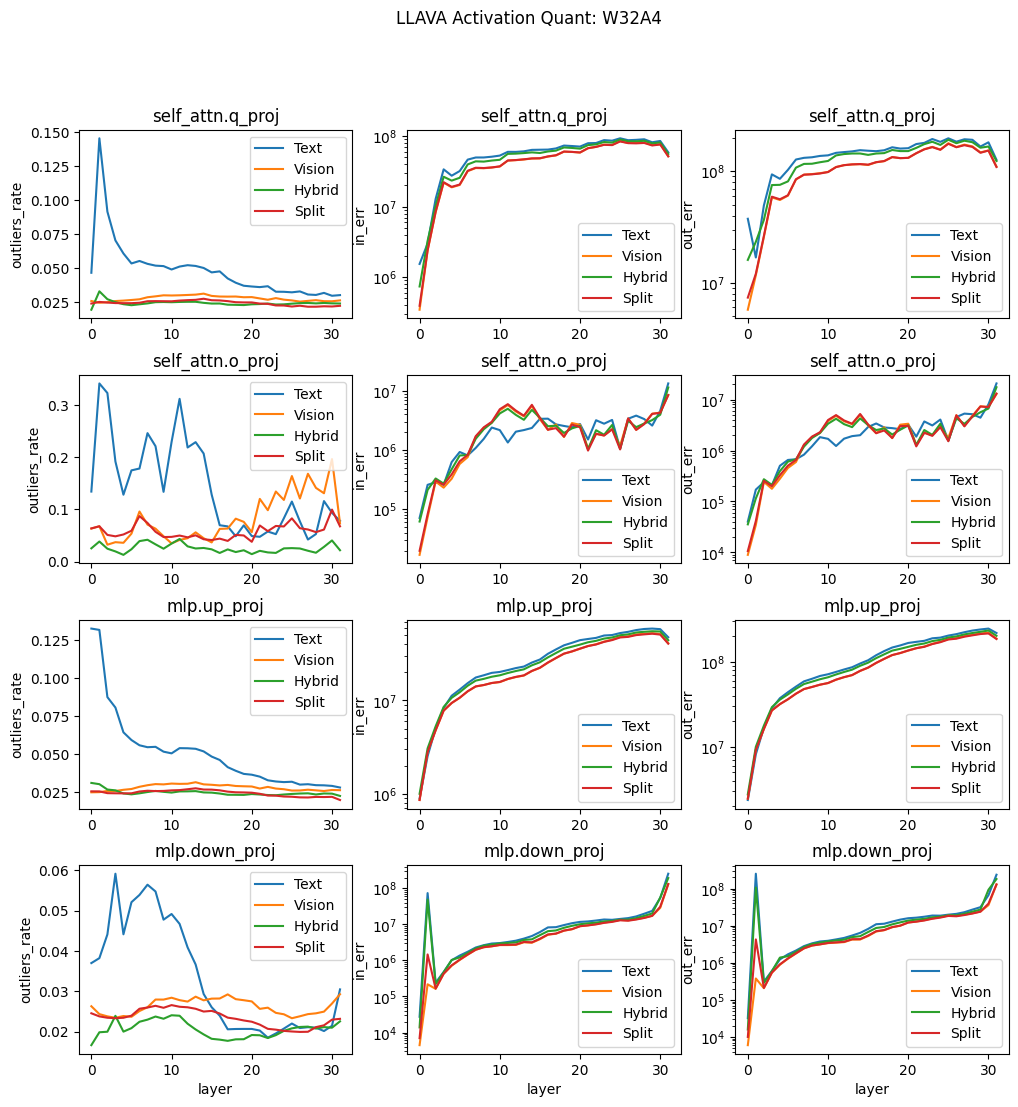

In [14]:
plt.figure(figsize=(12, 12))
plt.subplots_adjust(hspace=0.3)
for j, comp in enumerate(comps):
    ax = plt.subplot(4, 3, j * 3 + 1)
    plot_comp(ax, collected[comp], 'outliers_rate')
    if j == len(comps) - 1:
        ax.set_xlabel('layer')
    ax.set_title(comp)
    ax = plt.subplot(4, 3, j * 3 + 2)
    plot_comp(ax, collected[comp], 'in_err')
    ax.set_yscale('log')
    if j == len(comps) - 1:
        ax.set_xlabel('layer')
    ax.set_title(comp)
    ax = plt.subplot(4, 3, j * 3 + 3)
    plot_comp(ax, collected[comp], 'out_err')
    ax.set_yscale('log')
    if j == len(comps) - 1:
        ax.set_xlabel('layer')
    ax.set_title(comp)
plt.suptitle(f'LLAVA Activation Quant: W32A4')
plt.savefig(os.path.join(log_dir, 'img', f'w32a4.png'))